In [1]:
# Install the package for loading data into the file system
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=66fe752feff2c28f15781fb27c98c952fb05852a757fbdec1f10a8c6be2a2362
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
# # Install the required libraries
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time
import wget
import nltk
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Downloading data from the network to the file system
def load_txt_data():
    print('Downloading dataset')
    # data location address on the network | test
    test_url = 'http://www.hlt.utdallas.edu/~vince/data/emnlp12/test.c.txt'
    # Download the file, after checking its absence in the system
    if not os.path.exists('./test.c.txt'):
        wget.download(test_url, './test.c.txt')

    # data location address on the network | train
    train_url = 'http://www.hlt.utdallas.edu/~vince/data/emnlp12/train.c.txt'
    # Download the file, after checking its absence in the system
    if not os.path.exists('./train.c.txt'):
        wget.download(train_url, './train.c.txt')
        
# loading data from the file system and their preprocessing
def data_preprocessing():
    # test
    test_list_source_target_sents = []
    with open("test.c.txt", "r") as file:
        for line in file:
            test_list_source_target_sents.append(line.split("\n")[0])
    
    test_list_source_target_sents = list(filter(('').__ne__, test_list_source_target_sents))

    # train
    train_list_source_target_sents = []
    with open("train.c.txt", "r") as file:
        for line in file:
            train_list_source_target_sents.append(line.split("\n")[0])
    
    train_list_source_target_sents = list(filter(('').__ne__, train_list_source_target_sents))
    
    # Creation of a general corpus to create the vocabulary required for tokenization
    list_source_target = train_list_source_target_sents + test_list_source_target_sents
    
    return list_source_target

# Create pairs: source / target 
def pairs_source_target(list_source_target_sents):
    list_source_sent = []
    list_target_sent = []
    util_target_list = []
    separator = ', '

    for indx in range(0, len(list_source_target_sents), 4):
        
        list_source_sent.append(list_source_target_sents[indx])
        
        util_target_list.append(list_source_target_sents[indx+1:indx+4])
        util_target_list = separator.join(util_target_list[0])
        
        list_target_sent.append(util_target_list.replace(', ', ',').replace(',', ' '))
        util_target_list = []
        
    return list_source_sent, list_target_sent

# Convert unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # create a space between the word and the punctuation mark
    # example: "He was a student." => "he was a student ."
    # source:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replace everything with spaces except (a-z, A-Z, ".", "?", "!", ",") 
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # add the start and end tokens
    # now the model will know where the prediction starts and ends
    w = '<start> ' + w + ' <end>'
    return w

# create pairs in the format: [source, target]
def create_dataset(source, target):

    new_source = [[preprocess_sentence(s)] for s in source]
    new_target = [[preprocess_sentence(t)] for t in target]
    
    return sum(new_source, []), sum(new_target, [])

# Tokenizing words
def tokenize(seq):
    seq_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    seq_tokenizer.fit_on_texts(seq)

    tensor = seq_tokenizer.texts_to_sequences(seq)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    return tensor, seq_tokenizer

# create the final data
def load_dataset(source, target):
    
    inp_seq ,targ_seq = create_dataset(source, target)

    input_tensor, inp_seq_tokenizer = tokenize(inp_seq)
    target_tensor, targ_seq_tokenizer = tokenize(targ_seq)

    return input_tensor, target_tensor, inp_seq_tokenizer, targ_seq_tokenizer

# Index to word mapping
def convert(seq, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, seq.index_word[t]))
            
# Converting a tensor to a sentence
def convert_str(seq, tensor):
  empty_str = ''
  for t in tensor:
    if t!=0:
      empty_str += seq.index_word[t] + ' '
  empty_str = empty_str.replace('<start>', '')   
  empty_str = empty_str.replace('<end>', '')
  return empty_str

# Function for assessing quality by BLEU metric on test data
def BLEUscore_test(inp_sequence, targ_sequence, input_tensor, target_tensor):
    accum_score = 0

    for indx in range(len(input_tensor)):

        predicted, _, _ = evaluate(convert_str(inp_sequence, input_tensor[indx]))
        predicted = predicted.replace('<end>', '')
        predicted = predicted.split(' ')
        predicted = list(filter(('').__ne__, predicted))

        targ_str = convert_str(targ_sequence, target_tensor[indx])
        targ_str = targ_str.split(' ')
        targ_str = list(filter(('').__ne__, targ_str))

        accum_score += nltk.translate.bleu_score.sentence_bleu([targ_str], predicted)
        

    BLEUscore = accum_score / len(input_tensor)
    return BLEUscore

In [4]:
# Implementing encoder
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

# implement attention mechanism
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        
        query_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights
    
# Implementing decoder
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = Attention(self.dec_units)

    def call(self, x, hidden, enc_output):
        
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)

        output = tf.reshape(output, (-1, output.shape[2]))

        x = self.fc(output)

        return x, state, attention_weights

# loss function
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

# The main function of training the model
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_seq.word_index['<start>']] * BATCH_SIZE, 1)

        # передает цель в качестве следующего входного сигнала
        for t in range(1, targ.shape[1]):
            # передаем выход кодера в декодер
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

# Predictions
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_seq.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                            maxlen=max_length_inp,
                                                            padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_seq.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                                dec_hidden,
                                                                enc_out)

        # saving attention weights for plotting
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_seq.index_word[predicted_id] + ' '

        if targ_seq.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # return the predicted index to the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

# Function for displaying attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    
# predicted sequence generation function
def predict(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))
    return result

In [5]:
# Downloading data from the network to the file system
load_txt_data()

In [6]:
print(os.listdir())

['.config', 'train.c.txt', 'test.c.txt', 'sample_data']


In [7]:
# loading data from the file system and their preprocessing
list_source_target_sents = data_preprocessing()
len(list_source_target_sents)

7544

In [8]:
# Create pairs: source / target 
list_source_sent, list_target_sent = pairs_source_target(list_source_target_sents) 
list_source_sent[5], list_target_sent[5]

('The bus driver yelled at a kid after she broke a window.',
 'she The bus driver a kid a kid')

In [9]:
# Let's create pairs in the format: [source, target]
source_list, target_list = create_dataset(list_source_sent, list_target_sent)

In [10]:
source_list[0], target_list[0]

('<start> the bee landed on the flower because it had pollen . <end>',
 '<start> it the bee the flower the flower <end>')

In [11]:
# Let's create the final data and see the sample data
input_tensor, target_tensor, inp_seq, targ_seq = load_dataset(list_source_sent, list_target_sent)

# Let's see the maximum length of tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [12]:
input_tensor[0], target_tensor[0]

(array([   3,    1, 1471, 1472,   28,    1, 1473,    6,   15,   30, 1474,
           2,    4,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0], dtype=int32),
 array([  2,   6,   1, 425,   1, 426,   1, 426,   3,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0], dtype=int32))

In [13]:
max_length_targ, max_length_inp

(20, 39)

In [14]:
# Map indices to words
print ("Input sequence; index to word mapping")
convert(inp_seq, input_tensor[0])
print ()
print ("Target sequence; index to word mapping")
convert(targ_seq, target_tensor[0])

Input sequence; index to word mapping
3 ----> <start>
1 ----> the
1471 ----> bee
1472 ----> landed
28 ----> on
1 ----> the
1473 ----> flower
6 ----> because
15 ----> it
30 ----> had
1474 ----> pollen
2 ----> .
4 ----> <end>

Target sequence; index to word mapping
2 ----> <start>
6 ----> it
1 ----> the
425 ----> bee
1 ----> the
426 ----> flower
1 ----> the
426 ----> flower
3 ----> <end>


In [15]:
# Let's create training and test datasets
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(
    input_tensor, target_tensor, test_size=0.1)

# Let's see the dimensions
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

1697 1697 189 189


In [16]:
input_tensor_val[0]

array([   3,  647,  782,  385, 1353,   18,   20,  222,  964,   16,    7,
         69,   49,    5,  626, 1401,   34,   49,    2,    4,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [17]:
target_tensor_val[0]

array([   2,    4,  191,  331,   13, 1007,  296,  191,  331,    3,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [18]:
# Convert a tensor to a sentence
conv_str = convert_str(inp_seq, input_tensor_val[0])
conv_str

' american airlines offers upgrades for their preferred passengers since they want them to continue flying with them .  '

In [19]:
# Create tf.data dataset and hyperparameters
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 16
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
attention_units = 10
vocab_inp_size = len(inp_seq.word_index)+1
vocab_tar_size = len(targ_seq.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [20]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([16, 39]), TensorShape([16, 20]))

In [21]:
# Initializing the encoder
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# Encoder Output and Hidden State Sizes
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (16, 39, 1024)
Encoder Hidden state shape: (batch size, units) (16, 1024)


In [22]:
# Initializing Attention
attention_layer = Attention(attention_units)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (16, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (16, 39, 1)


In [23]:
# decoder initialization
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (16, 1448)


In [24]:
# Defining an optimizer and a loss function
learning_rate=0.001  # 0.00025
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [25]:
# Save model breakpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [26]:
# Model training
EPOCHS = 20 

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))
    # Save the model every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.5930
Epoch 1 Batch 50 Loss 1.6661
Epoch 1 Batch 100 Loss 1.9174
Epoch 1 Loss 1.9136
Time taken for 1 epoch 30.580141305923462 sec

Epoch 2 Batch 0 Loss 1.9409
Epoch 2 Batch 50 Loss 1.6198
Epoch 2 Batch 100 Loss 1.6115
Epoch 2 Loss 1.6077
Time taken for 1 epoch 10.55054259300232 sec

Epoch 3 Batch 0 Loss 1.4998
Epoch 3 Batch 50 Loss 1.5297
Epoch 3 Batch 100 Loss 1.1268
Epoch 3 Loss 1.4570
Time taken for 1 epoch 10.55422830581665 sec

Epoch 4 Batch 0 Loss 1.3206
Epoch 4 Batch 50 Loss 1.4371
Epoch 4 Batch 100 Loss 1.3977
Epoch 4 Loss 1.3092
Time taken for 1 epoch 10.57076120376587 sec

Epoch 5 Batch 0 Loss 1.2863
Epoch 5 Batch 50 Loss 1.0349
Epoch 5 Batch 100 Loss 1.0870
Epoch 5 Loss 1.1324
Time taken for 1 epoch 10.53599238395691 sec

Epoch 6 Batch 0 Loss 0.9178
Epoch 6 Batch 50 Loss 0.8523
Epoch 6 Batch 100 Loss 0.9572
Epoch 6 Loss 0.9724
Time taken for 1 epoch 10.702862739562988 sec

Epoch 7 Batch 0 Loss 0.8853
Epoch 7 Batch 50 Loss 0.8313
Epoch 7 Batch 100 Loss 

In [ ]:
# Restoring the last checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> lions eat zebras because they are meaty . <end>
Predicted: they lions zebras zebras <end> 


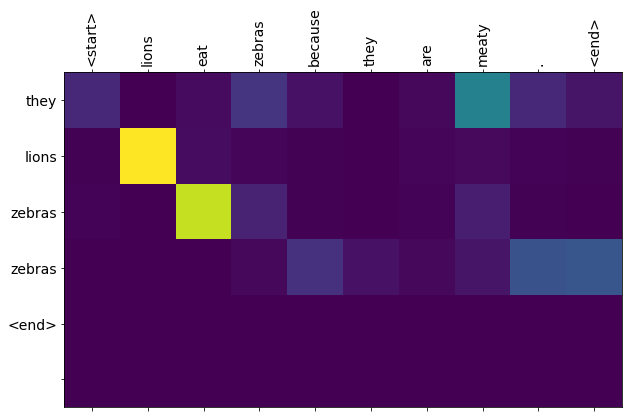

In [27]:
# Correct sequence of 2nd, 3rd, 4th lines:
# they
# Lions,zebras
# zebras
predicted = predict(u"Lions eat zebras because they are meaty.")

Input: <start> john hired bill because he needed someone . <end>
Predicted: he john bill john <end> 


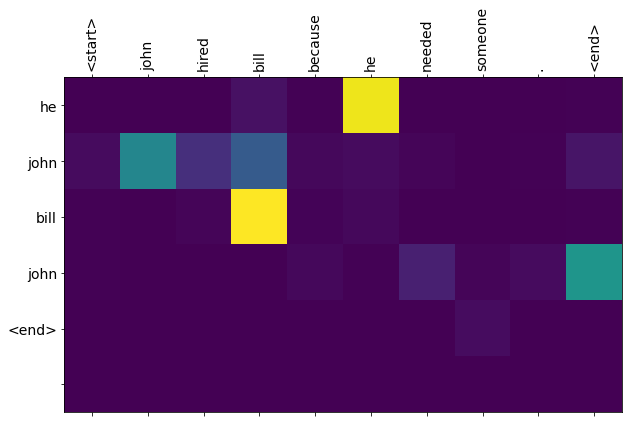

In [28]:
predicted = predict(u"John hired Bill because he needed someone.")

True target:  they monkeys lions lions  
Input: <start> monkeys hate lions because they are scary . <end>
Predicted: they monkeys lions monkeys <end> 


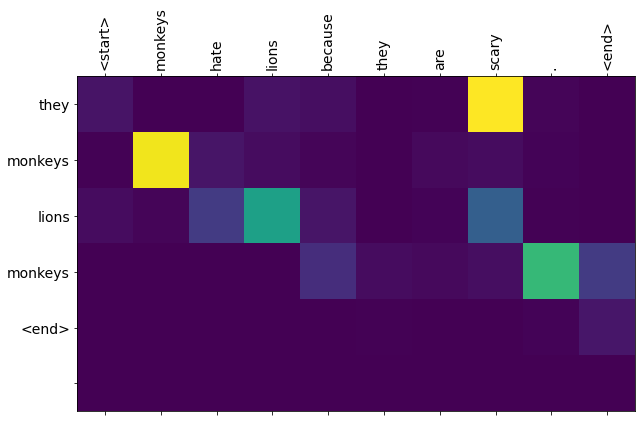

In [29]:
print(f'True target: {convert_str(targ_seq, target_tensor_val[55])}')
predicted = predict(convert_str(inp_seq, input_tensor_val[55]))

In [30]:
# The quality of the model's performance on test data that the model has never seen
BLEU = BLEUscore_test(inp_seq, targ_seq, input_tensor_val, target_tensor_val)
print(f'BLEU Score = {BLEU}')

BLEU Score = 0.6541912640877456
